In [1]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from cartopy import crs, feature
import copy

import cmocean as cm
cmap_deep = cm.cm.deep
cmap_deep = copy.copy(cmap_deep)
cmap_deep.set_bad('k')
cmap_div = cm.cm.balance
cmap_abs = cm.cm.matter
cmap_tau = cm.cm.oxy

In [2]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}

# Checking Resuspension and Velocities at coastline

In [3]:
def date_files(date, path, prefix_type= 'grid_T.nc'):
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, folder + f'/SalishSea_1h_{date.strftime("%Y%m%d").lower()}_{date.strftime("%Y%m%d").lower()}_{prefix_type}*')
    file_name = glob.glob(prefix) 
    return file_name

In [4]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return timestamps

In [5]:
# based on the 60 days run without buried particles, this time is when particles are mostly sedimented
#                       |
#                       |
#                       v
begin = datetime(2022,2,27)
end = datetime(2022,3,2)
#end = datetime(2016,3,10)
t_len = (end - begin).days
#
dates = get_timestamps(begin,t_len)
hourly_dates = pd.date_range(start=begin, end=end, freq='H')[:-1]

/tmp/ipykernel_2838780/997312696.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_dates = pd.date_range(start=begin, end=end, freq='H')[:-1]


In [6]:
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
files_e3t = []
for i in range(t_len):
    files_e3t.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_T.nc'))
    #
files_U = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    #
files_V = []
for i in range(t_len):
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))

In [7]:
coords = xr.open_dataset(path['coords'], decode_times=False)
lon = coords['nav_lon'].values
lat = coords['nav_lat'].values
#
mask = xr.open_dataset(path['mask'])
bathy = xr.open_dataset(path['bat'])

In [8]:
xr.open_dataset(files_U[-1][0])

<xarray.Dataset> Size: 1GB
Dimensions:               (y: 898, x: 398, nvertex: 4, depthu: 40,
                           axis_nbounds: 2, time_counter: 24)
Coordinates:
    nav_lat               (y, x) float32 1MB ...
    nav_lon               (y, x) float32 1MB ...
  * depthu                (depthu) float32 160B 0.5 1.5 2.5 ... 414.5 441.5
    time_centered         (time_counter) datetime64[ns] 192B ...
  * time_counter          (time_counter) datetime64[ns] 192B 2022-03-01T00:30...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lon            (y, x, nvertex) float32 6MB ...
    bounds_lat            (y, x, nvertex) float32 6MB ...
    area                  (y, x) float32 1MB ...
    depthu_bounds         (depthu, axis_nbounds) float32 320B ...
    vozocrtx              (time_counter, depthu, y, x) float32 1GB ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 384B ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 384B ...
Attributes:
    name:         SalishSea_1h_20220301_20220305
    description:  U velocity
    title:        U velocity
    Conventions:  CF-1.6
    timeStamp:    2022-Dec-24 13:47:12 GMT
    uuid:         69044bc9-6651-4e5c-bf99-e341f7db5013

In [9]:
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)

Review velocity near the coastline and check resuspenssion there :D

In [10]:
depth = mask.mbathy[0] - 1
time = 12 # noon
U_x = xr.open_dataset(files_U[-1][0])['vozocrtx'][time,depth,:,:]
U_y = xr.open_dataset(files_V[-1][0])['vomecrty'][time,depth,:,:]
ssh = xr.open_dataset(files_e3t[-1][0])['sossheig'][time,:,:]
e3t = xr.open_dataset(files_e3t[-1][0])['e3t'][time,depth,:,:]
td = xr.open_dataset(path['mask'])['totaldepth']
#
# H_VEL^2
#U_squared = (U_x**2 + U_y**2)# + 5e-4

In [11]:
U_x_unstaggered = 0.5 * (U_x.isel(x=slice(0, -1), y=slice(0, -1)) + U_x.isel(x=slice(1, None), y=slice(0, -1)))
U_y_unstaggered = 0.5 * (U_y.isel(x=slice(0, -1), y=slice(0, -1)) + U_y.isel(x=slice(0, -1), y=slice(1, None)))
U_squared = (U_x_unstaggered**2 + U_y_unstaggered**2)

In [12]:
U_squared.shape

(897, 397)

/tmp/ipykernel_2838780/1596330963.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(mask['nav_lon'], mask['nav_lat'], td - e3t)
/tmp/ipykernel_2838780/1596330963.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)


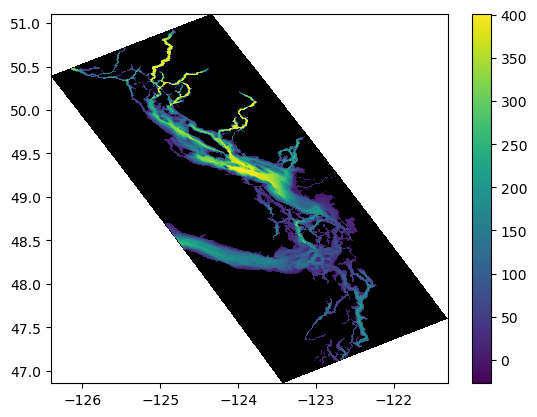

In [13]:
plt.pcolormesh(mask['nav_lon'], mask['nav_lat'], td - e3t)
plt.colorbar()
plt.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)


In [14]:
fact = (1 + ssh / td)
log_e3t = np.log(e3t * fact)
tau_critc = 5e-4
log_z_star = np.log(0.07)
vtau_constant = tau_critc / ((0.42 ** 2) * 1024)  
value_tau = vtau_constant * (log_e3t - log_z_star) ** 2

In [15]:
tau_res = value_tau[:-1, :-1].where(value_tau[:-1, :-1] <= U_squared)
color_tau_res = ['green']
cmap_tau_res = ListedColormap(color_tau_res)
#
tau_NO_res = value_tau[:-1, :-1].where(value_tau[:-1, :-1] > U_squared)
color_tau_NO_res = ['red']
cmap_tau_NO_res = ListedColormap(color_tau_NO_res)

Load OP output to see sedimented particles

In [16]:
data = xr.open_dataset('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_180_days_no_buried_tau_crit_5e-4_upwards_from_bottom_added.zarr')
#data = xr.open_dataset('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_60_days_no_buried.zarr')
#data = xr.open_dataset('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_60_days_no_buried_tau_crit_5e-4.zarr')

/home/vvalenzuela/conda_envs/analysis-vicente/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/vvalenzuela/conda_envs/analysis-vicente/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


/tmp/ipykernel_2838780/844267345.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
/tmp/ipykernel_2838780/844267345.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax2.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
/tmp/ipykernel_2838780/844267345.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply

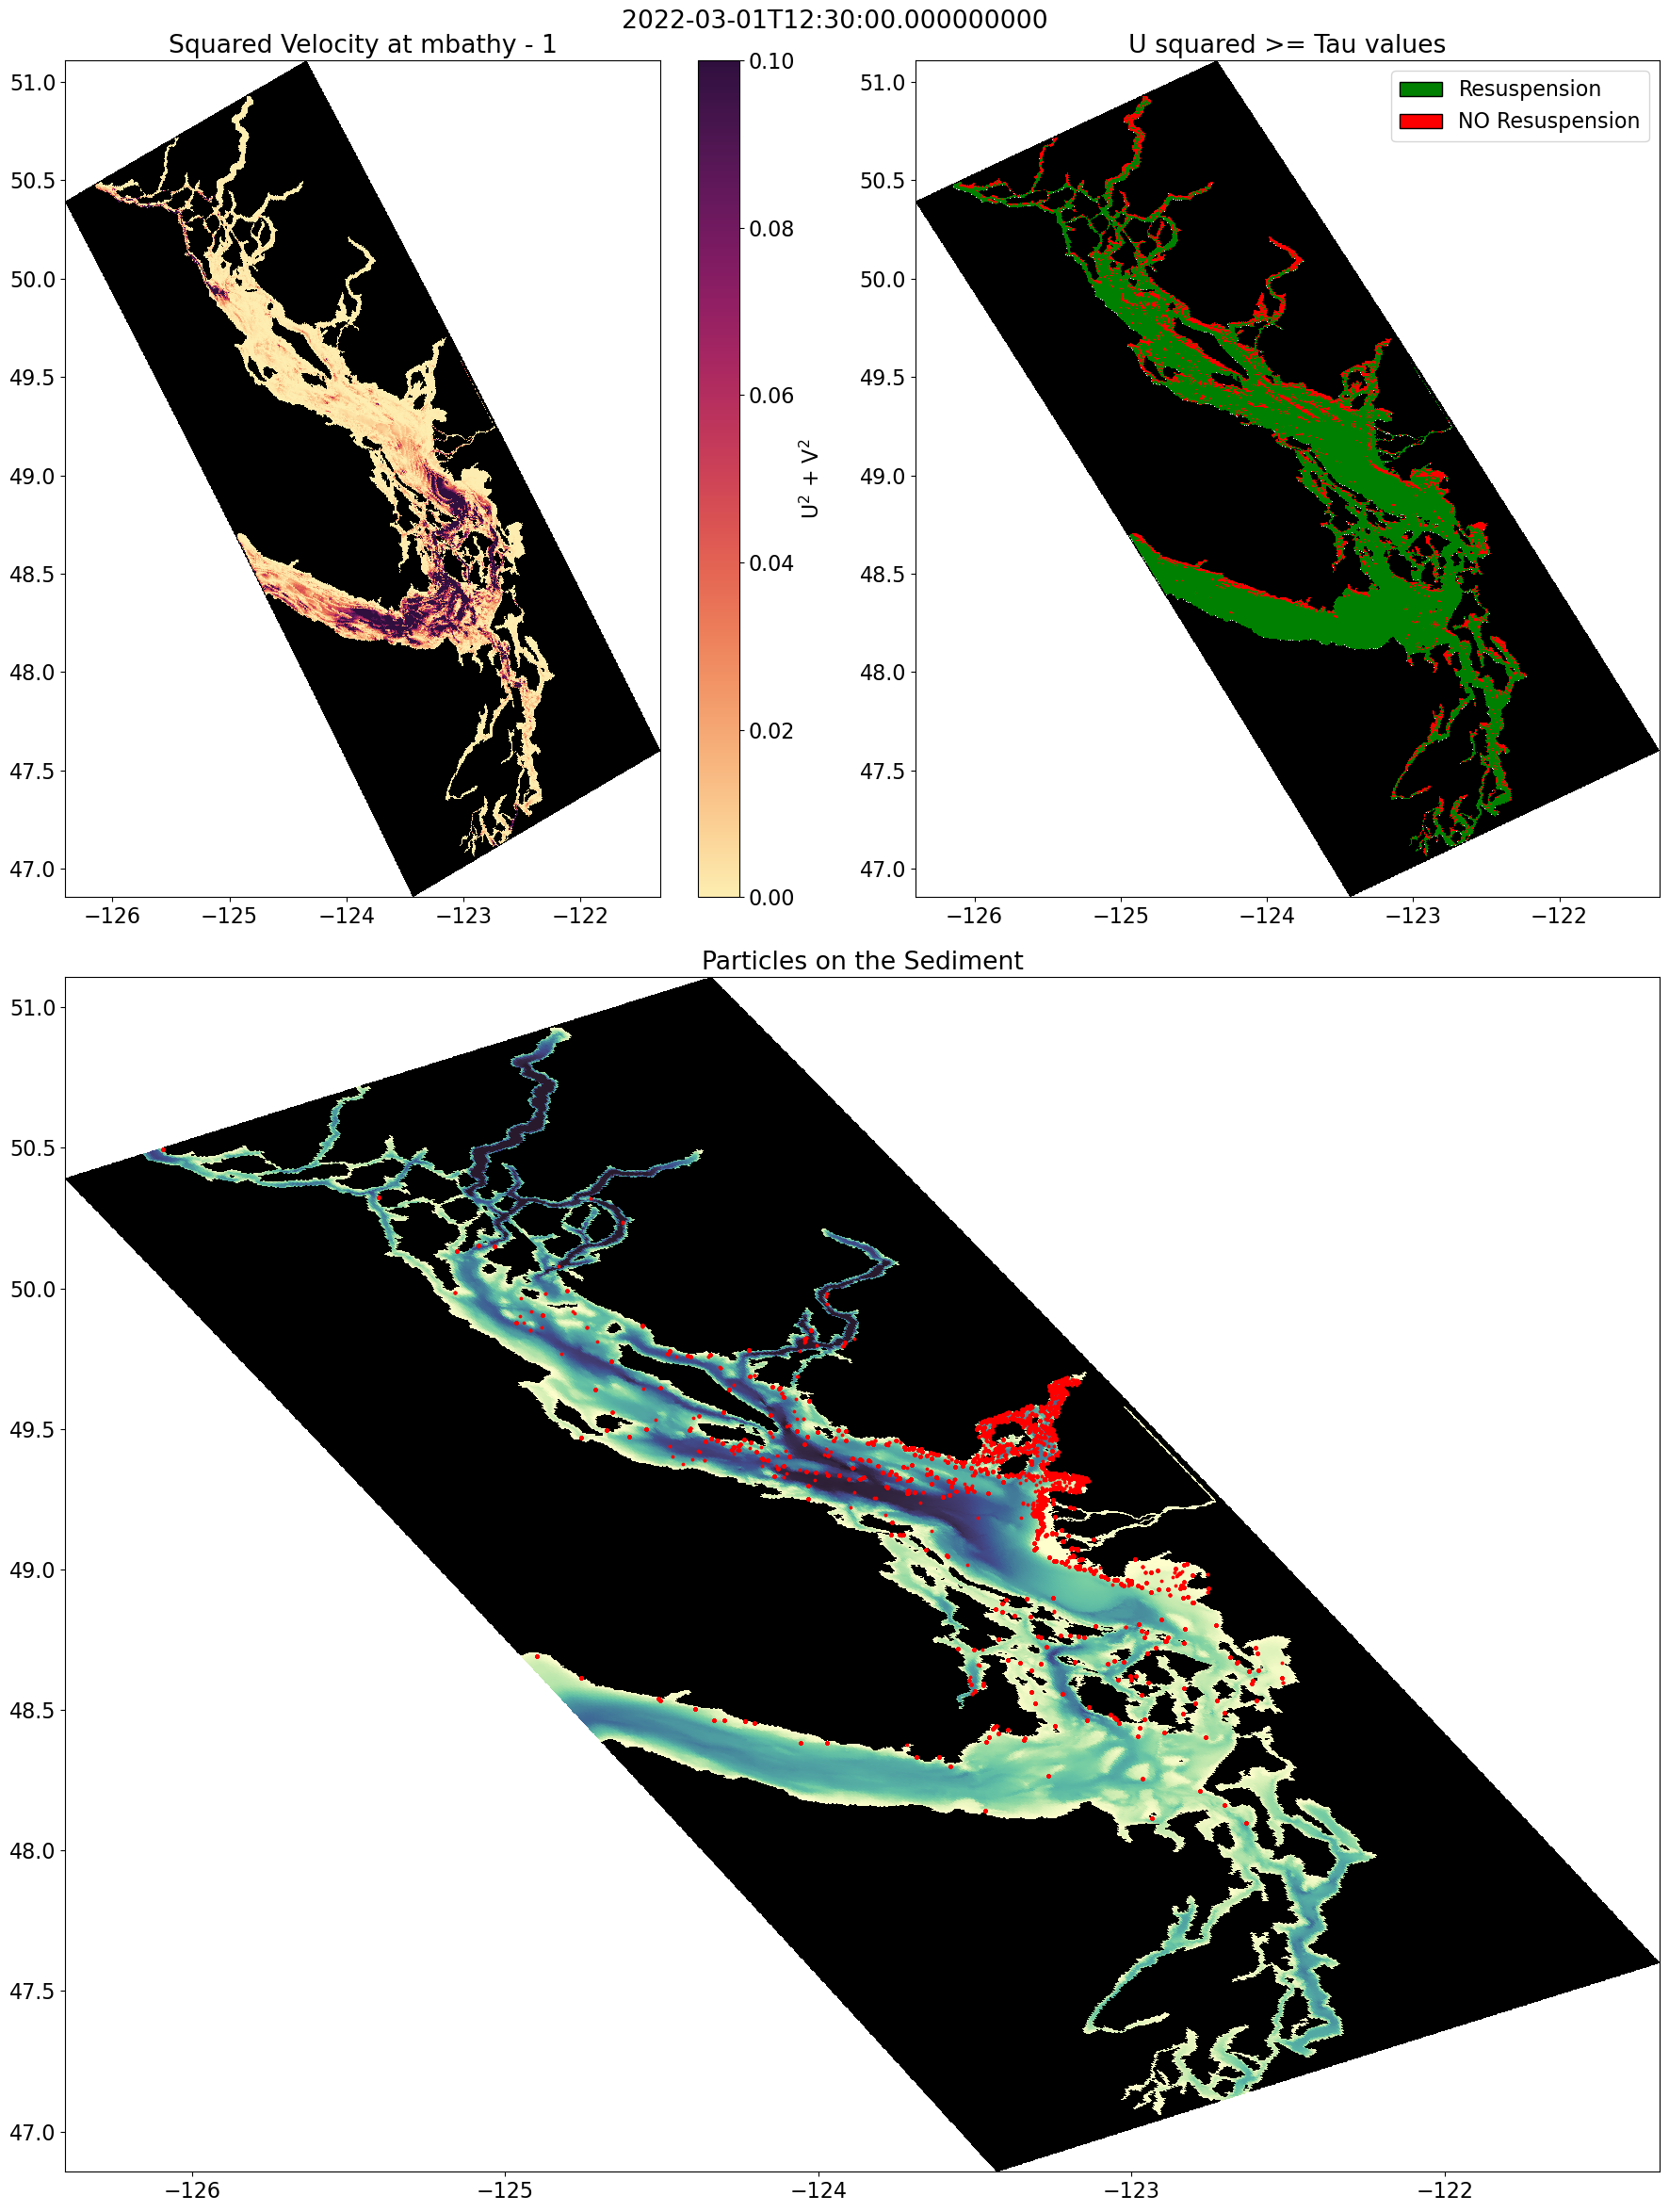

In [17]:
lim_min, lim_max = 0, 0.1
#
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(18, 24))
gs = gridspec.GridSpec(2, 2, height_ratios=[.7, 1])
#
ax1 = fig.add_subplot(gs[0, 0])  # Top left
ax2 = fig.add_subplot(gs[0, 1])  # Top right
#
ax3 = fig.add_subplot(gs[1, :])  # Full width

# --- Squared velocity ---
vel_squared = ax1.pcolormesh(lon, lat, U_squared, cmap=cmap_abs, vmin=lim_min, vmax=lim_max)
ax1.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
fig.colorbar(vel_squared, ax=ax1, label=r'U$^2$ + V$^2$')
ax1.set_title('Squared Velocity at mbathy - 1')

# --- Resuspension mask ---
legend_elements = [
    Patch(facecolor='green', edgecolor='k', label='Resuspension'),
    Patch(facecolor='red', edgecolor='k', label='NO Resuspension')
]

ax2.pcolormesh(mask['nav_lon'], mask['nav_lat'], tau_res, cmap=cmap_tau_res)
ax2.pcolormesh(mask['nav_lon'], mask['nav_lat'], tau_NO_res, cmap=cmap_tau_NO_res)
ax2.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
ax2.legend(handles=legend_elements, loc='upper right')
ax2.set_title('U squared >= Tau values')

# --- Particle map ---
bathy_plot = ax3.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap=cmap_deep)
sc = ax3.scatter(
    data.lon.where(data.status > 10),
    data.lat.where(data.status > 10),
    c='r',
    s=3
)
ax3.set_title('Particles on the Sediment')
plt.suptitle(U_x['time_counter'].values)

plt.tight_layout()
plt.show()

In [18]:
from salishsea_tools import viz_tools

In [19]:
u = xr.open_dataset(files_U[0][0])

In [21]:
out_u = viz_tools.unstagger_xarray(u, 'x')

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

Squared velocity ($U^2 + V^2$) is producing zero values at some places near the coast, when the Field is set at mbathy -1. This means that the second last grid cell of the model is stil giving zero values for U and V, making resuspension not effective, which results in particles beaching and staying sedimented

/tmp/ipykernel_1500133/1331599027.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)


Text(0.5, 1.0, 'Squared Velocity (U^2 + V^2)  = 0 \n at mbathy -1')

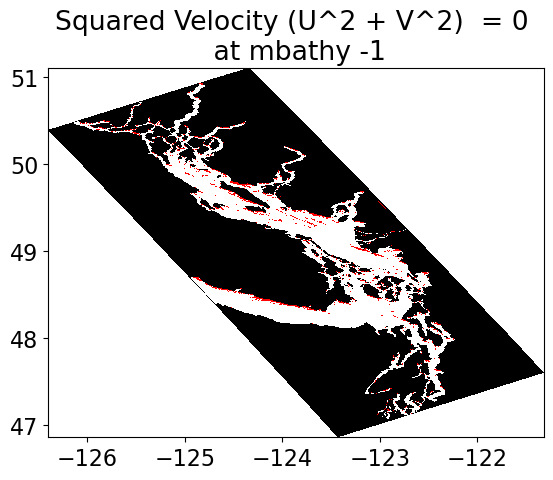

In [20]:
plt.pcolormesh(lon, lat, U_squared.where(U_squared == 0), cmap=cmap_tau_NO_res, vmin=lim_min, vmax=lim_max)
plt.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
plt.title('Squared Velocity (U^2 + V^2)  = 0 \n at mbathy -1')

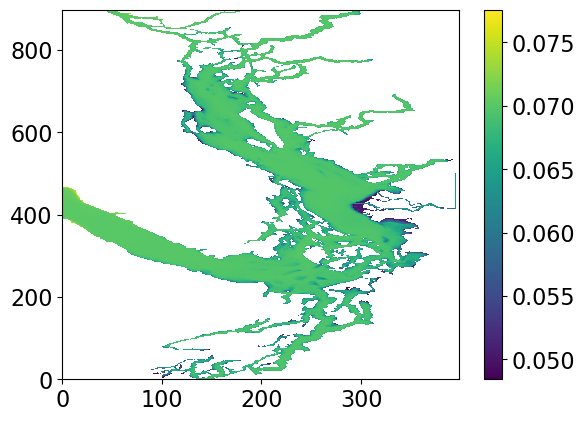

In [21]:
#plt.pcolormesh(td - (td - e3t))
plt.pcolormesh((0.07)/fact)

plt.colorbar()

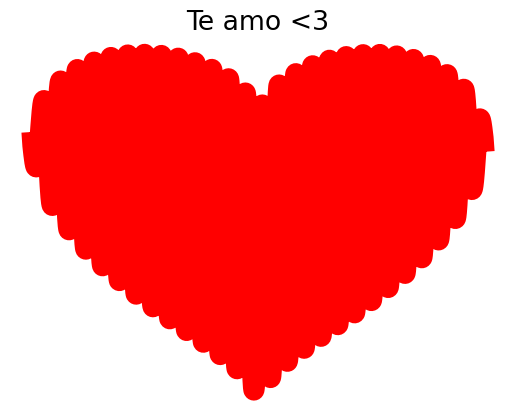

In [22]:
import numpy as np
import matplotlib.pyplot as plt
#
x = np.linspace(-20, 20, 100000)
inside_sqrt = ((np.e**2) - (x**2)) / 2
inside_sqrt[inside_sqrt < 0] = np.nan  
y = np.sin((np.pi**3) * x) * np.sqrt(inside_sqrt) + np.sqrt(np.abs(x))
plt.plot(x, y, c='red', linewidth=15)
plt.title('Te amo <3')
plt.axis('off')
plt.show()